# Neural Network Basics

Use **Code** cells to write and run any code you need to answer the question and **Markdown** cells to write out answers in words. After you are finished with the assignment, remember to download it as an **HTML file** and submit it in **ELMS**.

In [ ]:
!pip install tensorflow

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
import os 
cwd = os.getcwd()


In [3]:
csv_file = tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/download.tensorflow.org/data/heart.csv')
df = pd.read_csv(csv_file)


In [4]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,52,1,1,118,186,0,2,190,0,0.0,2,0,fixed,0
299,43,0,4,132,341,1,2,136,1,3.0,2,0,reversible,1
300,65,1,4,135,254,0,2,127,0,2.8,2,1,reversible,1
301,48,1,4,130,256,1,2,150,1,0.0,1,2,reversible,1


## Neural Networks 

In this notebook, we will go over how to train neural network models to do supervised machine learning using tensorflow. This is mostly to demonstrate how the code works and how one goes about building these types of models. A more detailed explanation of what exactly is going on behind the scenes and the math behind the implementation is reserved for another class. 

### Machine Learning 

Before we talk about neural networks, however, we should first reiterate what we mean when we talk about machine learning:

> **One definition of machine learning**: Machine is said to learn when a machine improves on a task with respect to a performance measure.

In supervised modeling tasks, we are attempting to train a model that uses existing data to predict new data. For instance, we might use existing data on civil war outbreaks to predict future civil war outbreaks, or we might use data on reviews classified as good or bad to make a model that can predict a good or bad review based only on the text itself.



### Prediction Example

Let's take a look at a quick example of doing some prediction. The `ncbirths` dataset has information on births in North Carolina, including information about the mother, weeks of pregnancy, and whether the baby was a low birthweight baby or not.

In [5]:
ncbirths = pd.read_csv("ncbirths.csv").dropna()
ncbirths.head()


,fage,mage,mature,weeks,premie,visits,marital,racemom,hispmom,gained,weight,lowbirthweight,gender,habit
2,19.0,15,younger mom,37.0,full term,11.0,2.0,1,M,38.0,6.63,not low,female,nonsmoker
3,21.0,15,younger mom,41.0,full term,6.0,2.0,1,M,34.0,8.00,not low,male,nonsmoker
6,18.0,15,younger mom,37.0,full term,12.0,2.0,2,N,76.0,8.44,not low,male,nonsmoker
7,17.0,15,younger mom,35.0,premie,5.0,2.0,2,N,15.0,4.69,low,male,nonsmoker
9,20.0,16,younger mom,37.0,full term,13.0,2.0,1,N,52.0,6.94,not low,female,nonsmoker


To make some of our later assessments easier, we're going to "dummify" some of the categorical variables. This generate K-1 columns (1 for each category) each with a zero if that observation is a member of that category, or a 1 otherwise.

In [43]:
dummified = pd.get_dummies(ncbirths, columns=['lowbirthweight','racemom','habit','gender'],  
                            drop_first=True, dtype='int')

In [44]:
dummified.head()

,fage,mage,mature,weeks,premie,visits,marital,hispmom,gained,weight,lowbirthweight_not low,racemom_1,racemom_2,racemom_3,racemom_5,racemom_7,racemom_8,habit_smoker,gender_male
2,19.0,15,younger mom,37.0,full term,11.0,2.0,M,38.0,6.63,1,1,0,0,0,0,0,0,0
3,21.0,15,younger mom,41.0,full term,6.0,2.0,M,34.0,8.00,1,1,0,0,0,0,0,0,1
6,18.0,15,younger mom,37.0,full term,12.0,2.0,N,76.0,8.44,1,0,1,0,0,0,0,0,1
7,17.0,15,younger mom,35.0,premie,5.0,2.0,N,15.0,4.69,0,0,1,0,0,0,0,0,1
9,20.0,16,younger mom,37.0,full term,13.0,2.0,N,52.0,6.94,1,1,0,0,0,0,0,0,0


We'll try a very simple example of predicting the low birthweight status of the baby using the number of weeks that the pregnancy lasted. If we were to take a look at the relationship with a graph, it might look like the following. Note that `1` refers to low birthweight while `0` refers to not low birthweight. 

<Axes: xlabel='weeks', ylabel='lowbirthweight_not low'>

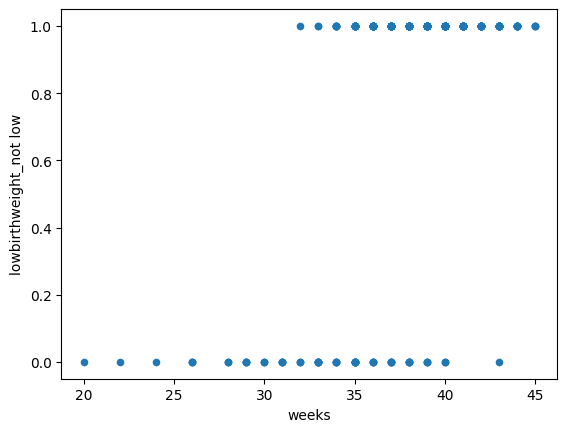

In [8]:
dummified.plot.scatter(y = 'lowbirthweight_not low', x = 'weeks')

So, how do we use `weeks` to predict the low birthweight status? Well, using a straight line to show the relationship wouldn't make sense. This is because low birthweight can only take one of two values: `0` or `1`. So, instead, we try to create a curved function that is constrained between 0 and 1 and represents the **probability** of low birth weight at different values of "weeks".

To do this, we'll model the relationship using a logistic or sigmoid function, which follows an S-shaped curve that is constrained between 0 and 1. You can see this function by running the commands below:

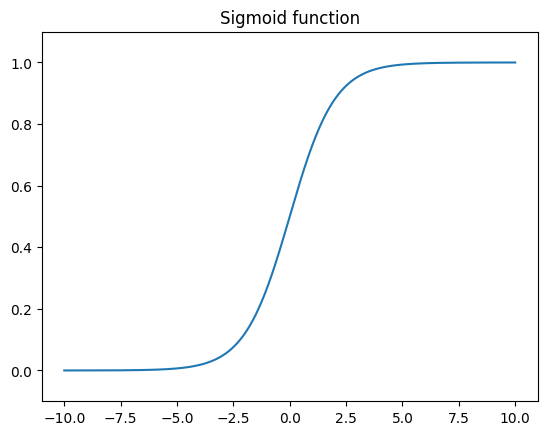

In [9]:
x = tf.linspace(-10, 10, 500)
x = tf.cast(x, tf.float32)
f = lambda x : (1/20)*x + 0.6
plt.plot(x, tf.math.sigmoid(x))
plt.ylim((-0.1,1.1))
plt.title("Sigmoid function");

In a logistic regession model, we attempt to find the parameters of this function that be most likely to have generated the observed data. 

## Running the model

Just like we did in the previous class, we'll try to avoid overfitting our data by splitting up the data into a training set and an evaluation set. 

In [10]:
y_data =dummified['lowbirthweight_not low'].tolist()

x_data = dummified.drop(columns=['lowbirthweight_not low'])

x_train, x_test, y_train, y_test = train_test_split(x_data,  y_data,
                                     test_size=0.20, # % of observations for validation
                                     random_state = 500
                                    ) # this is a random process, so you want to set a random seed! 




Let's take a look at what happens when we fit a logistic regression line.

In [13]:
#pred_cols = ['weeks']cols = 
pred_cols =['weeks',
        'gender_male', 'habit_smoker']

logit = LogisticRegression()
logit.fit(x_train[pred_cols], y_train)

LogisticRegression()

We can see how the model is operating by looking at some predictions at different values of "weeks":

<Axes: xlabel='weeks'>

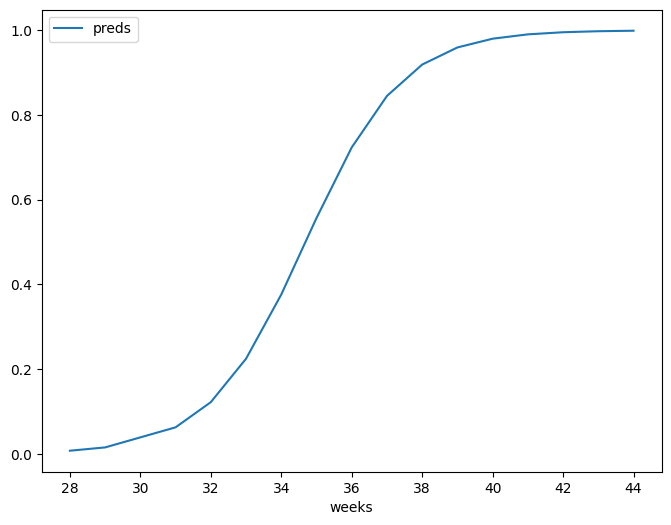

In [39]:


#pred_by_week = pd.DataFrame({'weeks': x_test.weeks, 'preds':preds}).sort_values('preds')
pred_by_week = pd.DataFrame({'weeks':x_test.weeks.sort_values().unique(), 'gender_male':1, 'habit_smoker':1})
pred_by_week['preds'] =logit.predict_proba(pred_by_week)[:,1]
fig, axes = plt.subplots(figsize=(8,6))
pred_by_week.plot.line('weeks','preds', ax = axes)


Now, we just want to use the model to predict our held-out data and then report the results. We'll use the same set of metrics we used in the previous class. First, we'll look at the confusion matrix to compare predictions to the actual labels:

In [18]:
preds = logit.predict_proba(x_test[pred_cols])[:,1]


pd.crosstab(y_test, preds>=.5,  margins=True).rename_axis(index = 'Truth', columns='Predictions')

Predictions,False,True,All
Truth,,,
0,8,6,14
1,2,145,147
All,10,151,161


And then we'll look at some summary statistics for our predictions

In [42]:
print(classification_report(y_test, preds>=.5, 
                            # add target_names to show labels in the report:
                            target_names=['Low Birth Weight', 'Not Low Birthweight']))

# add cohen's kappa and balanced accuracy
print("cohens kappa: ", cohen_kappa_score(y_test, preds>=.5))
print("balanced accuracy: ", balanced_accuracy_score(y_test, preds>=.5))

                     precision    recall  f1-score   support

   Low Birth Weight       0.80      0.57      0.67        14
Not Low Birthweight       0.96      0.99      0.97       147

           accuracy                           0.95       161
          macro avg       0.88      0.78      0.82       161
       weighted avg       0.95      0.95      0.95       161

cohens kappa:  0.640625
balanced accuracy:  0.7789115646258503


The predictions here are ok overall. Still, it looks like it might do well for some, but there are lots of points that it does poorly on. That's probably because we're just using one feature (variable) to make a prediction. In reality, we might want to use many features, and we might suspect that they have a complicated set of relationships with each other. Their effect on birthweight might be curvilinear, or be different depending on the prescence or absence of some other characteristic.

That's where something like neural networks might come in. The above logistic regression is an example of what one **node** in a neural network might look like. Neural networks essentially work by combining lots of these types of simple relationships to create a complex model that makes predictions. The key advantage of a neural network is that a sufficiently complex network can approximate **any functional relationship** between the predictors and the outcome that you could specify. 

![Neural Network](neural_network.png)

*Source: https://towardsdatascience.com/simple-introduction-to-neural-networks-ac1d7c3d7a2c*

To make our neural network, we'll start by converting our data into a format that tensorflow can use. We'll use the same set of predictor variables here that we used in the previous model:

In [48]:
cols = ['weeks','gender_male', 'habit_smoker']


In [47]:
x_train_tensor=tf.convert_to_tensor(x_train[cols])
x_test_tensor=tf.convert_to_tensor(x_test[cols])
y_train_tensor=tf.convert_to_tensor(y_train)
y_test_tensor = tf.convert_to_tensor(y_test)


Next, we'll create a normalization layer that will rescale our variables by subtracting their mean and then dividing them by their standard deviation. Neural networks have a tendency to overfit, especially on unbalanced data, and this kind of normalization is one way we can reduce that tendency. 

In [49]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(x_train_tensor))

In [50]:
# check out what this does on the first few rows of data:
normalizer(x_train_tensor[:3])


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[-0.50817317, -1.0078311 , -0.3359274 ],
       [-0.15178443, -1.0078311 , -0.3359274 ],
       [ 0.9173818 , -1.0078311 , -0.3359274 ]], dtype=float32)>

Now, we'll build a neural network by adding together several layers in a sequence. The `normalizer` layer just takes our input data and normalizes it. The `Dense` layers are "nodes": each one takes our input data and shifts and reweights it using an activation function. The final layer `Dense(1, activation='sigmoid')` is the output layer that converts the outputs from the nodes into a prediction that follows the same functional form as the logistic regression we performed earlier.

In [51]:
input_dim = x_train_tensor.shape[1]

model = Sequential([
  normalizer,
  Dense(64, activation='relu'),
  Dense(32, activation='relu'),
  Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
              
             )

In [52]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization)      │ (641, 3)                    │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7 (32.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7 (32.00 B)

Now we'll build our model and train it for 10 epochs. Since our classes are imbalanced, we'll also use a `class_weight` to make the the low birth weight cases get more consideration when training the model. This usually helps the network make better predictions when there is an imbalance between groups.

In [ ]:


history =  model.fit(x_train_tensor, y_train_tensor, 
                     # the number of iterations. This may need to go higher! Especially for compelx models
                     epochs=10,
                     validation_data = (x_test_tensor, y_test_tensor),
                     # controls the amount of output that is printed
                     verbose=1,
                     # adding a small weighting function.
                     class_weight =   {0:5., 1:1.}
                    )

In [54]:
model.evaluate(x_test_tensor,  y_test_tensor, verbose=2)

6/6 - 0s - 5ms/step - accuracy: 0.9255 - loss: 0.3675


[0.36751237511634827, 0.9254658222198486]

Now, we'll get our predictions and compare the results

In [55]:
preds = model.predict(x_test_tensor)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [56]:
pd.crosstab(y_test_tensor, preds.flatten()>=.5,  margins=True).rename_axis(index = 'Truth', columns='Predictions')

Predictions,False,True,All
Truth,,,
0,9,5,14
1,7,140,147
All,16,145,161


In [57]:
print(classification_report(y_test_tensor, preds>=.5, 
                            # add target_names to show labels in the report:
                              target_names=['Low Birth Weight', 'Not Low Birthweight']))


# add cohen's kappa and balanced accuracy
print("cohens kappa: ", cohen_kappa_score(y_test_tensor, preds>=.5))
print("balanced accuracy: ", balanced_accuracy_score(y_test_tensor, preds>=.5))

                     precision    recall  f1-score   support

   Low Birth Weight       0.56      0.64      0.60        14
Not Low Birthweight       0.97      0.95      0.96       147

           accuracy                           0.93       161
          macro avg       0.76      0.80      0.78       161
       weighted avg       0.93      0.93      0.93       161

cohens kappa:  0.5591054313099042
balanced accuracy:  0.7976190476190477


Is this better or worse than the prior model? Any thoughts as to why it might perform better?

### MNIST Data

Let's look at an example of applying neural network modeling to some image data. The MNIST dataset that comes with the `tensorflow` package contains images from handwritten digits (numbers). Our goal is to train a neural network that is able to accurately determine what number is written based on the data from the image. In other words, we want to build a neural network that is able to recognize numbers that have been handwritten. 

The data itself is structured so that it is in a 2-dimensional format for each observation. Each observation is 28 by 28, with the values within each cell representing the intensity of the pixel. These values make up the **features**, or variables that we use to predict/classify the observation as one of the 10 numerical digits. 


In [1387]:
# Load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Scale it so that the values are between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

To visually see what the data look like, let's graph some of the observations. 

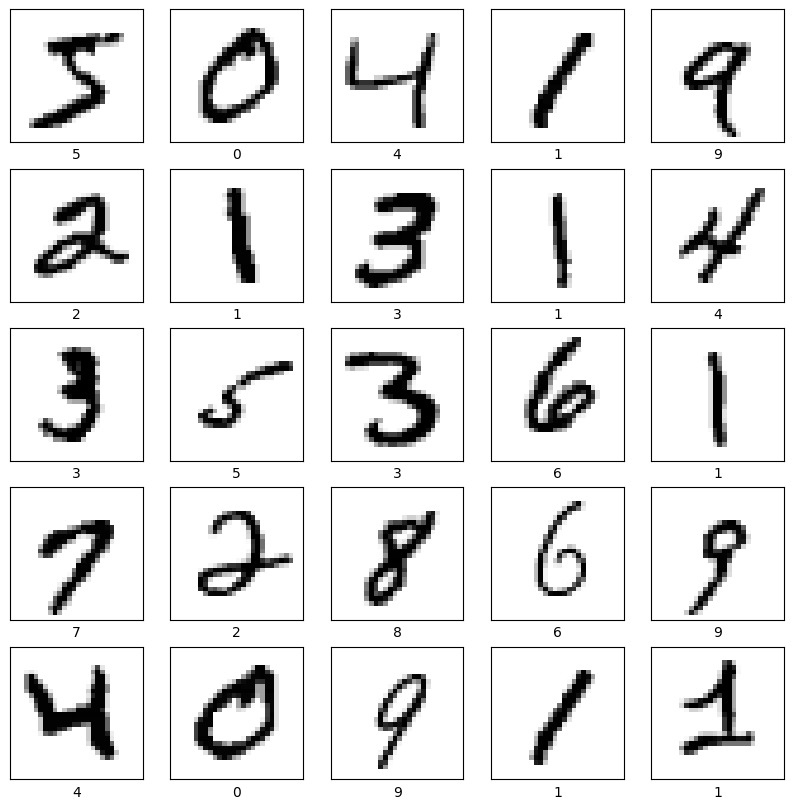

In [1388]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])

plt.show()

We specify the neural network model using `Sequential` and adding the layers in a list. 

Let's take a look at the layers one by one.
- `Flatten(input_shape=(28, 28))`: This flattens the 28 by 28 data into a 1-D format. There isn't anything being done to values at this step -- all that is happening is that the 2-D shape is being changed to a 1-D shape so that all of the same values are in a vector format.
- `Dense(128, activation='relu')` / `Dense(64, activation='relu')` : This is a dense layer, with the first argument specifying how many nodes there are. We have two dense layers in this neural network: one with 128 nodes and one with 64 nodes. You can imagine all of the features (variables) in our data feeding into every single one of the 128 nodes, and the outputs of those 128 nodes feeding into the 64 nodes in the next step. 
- `Dense(10)`: This is an **output layer**. Since we are trying to predict the image as being one of ten different categories (that is, the individual digits values from 0 to 9), we need a layer with 10 nodes.

In [1389]:
model = Sequential([
  Flatten(input_shape=(28, 28)),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dense(10)
])

C:\Users\neilb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Then, we need to compile the model, specify the loss function, and give it the metric we will use to evaluate how it is doing. 

In [1390]:
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Finally, we fit the model by giving it our data. Since we are using the training set to build our model, we give it the x and y data from the train. We also set the batch size and the number of epochs to 10. The **batch size** refers to how much of the data is used to fit the model at a time. An **epoch** refers to the number of times that the full data has been sent through the neural network. 

In [1391]:
model.fit(x_train, y_train, batch_size = 32, epochs=10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8817 - loss: 0.4117
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9692 - loss: 0.1022
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9785 - loss: 0.0697
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9841 - loss: 0.0516
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9865 - loss: 0.0404
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9894 - loss: 0.0347
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9914 - loss: 0.0263
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9931 - loss: 0.0213
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9928 - loss: 0.0201
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9939 - loss: 0.0176


## Evaluation

Now, let's take a look at how this would do on new data. We can use the `evaluate` method to apply our trained model to the test set and see how accurate it actually is.

In [1392]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - 1ms/step - accuracy: 0.9765 - loss: 0.0933


[0.09331011772155762, 0.9764999747276306]

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step


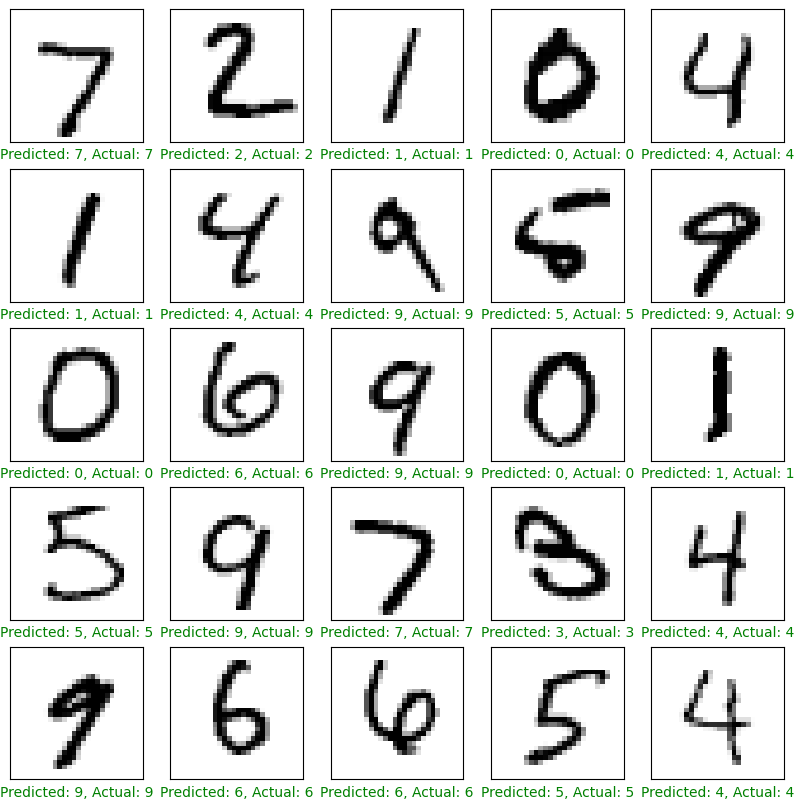

In [1393]:
predictions = model.predict(x_test)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    if np.argmax(predictions[i]) == y_test[i]:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel(f'Predicted: {np.argmax(predictions[i])}, Actual: {y_test[i]}', color = color)

plt.show()

### Next Steps

This is an example of using neural networks for image classification. There are lots of different applications of neural networks, though. For example, you can also use neural networks for **unsupervised learning** tasks, such as generative AI. Neural networks are also widely used in **text analysis** applications, such as sentiment analysis. 